In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')


In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    print("CUDA not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


torch.Size([250, 250, 3])


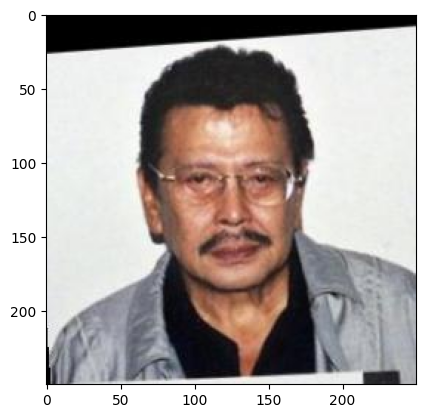

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Autoencoders vs. Variational Autoencoders (VAEs):**


1.   Applications:-

      Autoencoders: Mostly used for data compression, image denoising, and unsupervised learning.

      VAEs: Expanded to support probabilistic generative modeling, supporting interpolation, representation learning, and data generation applications.

2.   Architecture:-

    Autoencoders: A decoder reconstructs input from the latent space, while an encoder translates input to a fixed-size latent representation.

    VAEs: A probability distribution's latent space parameters are mapped from input by an encoder, and data is generated by a decoder using samples from the distribution.

3.   Loss Function:-

    Autoencoders: Reduce reconstruction loss (e.g., MSE, Binary Crossentropy) to the lowest possible level.

    VAEs: Add a new term that involves regularization and reconstruction los (KL Divergence), which promotes a particular probabilistic structure in the latent space.

4.   Latent Space Representation:-**

    Autoencoders: Generally speaking, latent space is a fixed-size vector with no particular probabilistic meaning.

    VAEs: To enable sampling and interpolation, latent space is represented as a probability distribution, frequently Gaussian. The probabilisticcharacter makes it easier to generate realistic and varied data.










# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Create VAE class containing encoder and decoder
class VAE(nn.Module):
    def __init__(self, latent_dims=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dims)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dims)

        # Decoder
        self.decoder_input = nn.Linear(latent_dims, 128 * 16 * 16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Output: [32, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # Output: [3, 128, 128]
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 128, 16, 16)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [9]:
# Create an instance of the VAE model
vae = VAE().to(device)

# Load a single batch of images
images, _ = next(iter(dataloader))
images = images.to(device)

# Reshape the images if necessary (the VAE expects [batch_size, 3, 250, 250])

# Forward pass through the model
decoded, mu, logvar = vae(images)

# Reparameterize to get latent space samples
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std

# Print the shapes of encoder
print("Shape of mu:", mu.shape)
print("Shape of logvar:", logvar.shape)
print("Shape of latent space samples (z):", z.shape)
print("Shape of decoded images:", decoded.shape)

Shape of mu: torch.Size([32, 20])
Shape of logvar: torch.Size([32, 20])
Shape of latent space samples (z): torch.Size([32, 20])
Shape of decoded images: torch.Size([32, 3, 250, 250])


#Explanation of how to create samples to latent space



*   An image is preprocessed and passed to the VAE model.
*   Applying the reparameterization trick with the mean (mu) and standard deviation (std) from the encoder creates new samples in the latent space.
*   New images are created from the sampled latent space using the decoder.

*   To ensure the forward pass is functioning properly, the original and generated images are displayed.




##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(vae):,} trainable parameters.')

optim = torch.optim.Adam(vae.parameters(), lr=1e-3)

The model has 4,071,867 trainable parameters.


In [11]:
def loss_function(recon_x, x, mu, logvar):
    # Custom logic for reconstruction loss
    reconstruction_loss = torch.mean(torch.abs(recon_x - x))

    # Custom logic for KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence

#Loss Function Explation

The loss function commonly used for training Variational Autoencoders (VAEs) consists of two terms: a reconstruction term and a regularization term.

Reconstruction Term:

This term measures how well the generated output matches the input. For images, the Binary Crossentropy (BCE) or Mean Squared Error (MSE) loss is often used. The goal is to minimize the difference between the original input and the reconstructed output. The reconstruction loss encourages the model to generate outputs that faithfully represent the input data.

Regularization Term (KL Divergence):

The Kullback-Leibler (KL) Divergence is used to regularize the latent space. The regularization term ensures that the distribution of the learned latent space approximates a chosen distribution, typically a standard Gaussian distribution (mean=0, std=1). This encourages the model to learn a well-structured and continuous latent space. The KL divergence penalizes deviation from the chosen distribution.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [12]:
# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        # Reset gradients
        optim.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = vae(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Calculate the average loss for those epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print("Training - Epoch: {:03d}/{:03d}, Loss: {:.4f}".format(epoch + 1, num_epochs, epoch_loss))


Training - Epoch: 001/100, Loss: 104382.1178
Training - Epoch: 002/100, Loss: 98803.7794
Training - Epoch: 003/100, Loss: 98405.5894
Training - Epoch: 004/100, Loss: 98058.4069
Training - Epoch: 005/100, Loss: 97820.4144
Training - Epoch: 006/100, Loss: 97611.3325
Training - Epoch: 007/100, Loss: 97448.3365
Training - Epoch: 008/100, Loss: 97333.5086
Training - Epoch: 009/100, Loss: 97193.3684
Training - Epoch: 010/100, Loss: 97082.8374
Training - Epoch: 011/100, Loss: 96991.6413
Training - Epoch: 012/100, Loss: 96906.7742
Training - Epoch: 013/100, Loss: 96818.4969
Training - Epoch: 014/100, Loss: 96746.5068
Training - Epoch: 015/100, Loss: 96658.4508
Training - Epoch: 016/100, Loss: 96552.0938
Training - Epoch: 017/100, Loss: 96379.3829
Training - Epoch: 018/100, Loss: 96255.9640
Training - Epoch: 019/100, Loss: 96127.5917
Training - Epoch: 020/100, Loss: 96057.3621
Training - Epoch: 021/100, Loss: 95982.8029
Training - Epoch: 022/100, Loss: 95911.7223
Training - Epoch: 023/100, Loss

* During training, it's essential to monitor the loss value to ensure that the model is learning effectively. If the loss is not decreasing, you might consider the following troubleshooting steps:*



1.   Learning Rate:

      Modify the optimizer's pace of learning. A learning rate that is too low could lead to sluggish convergence, and a learning rate that is too high could cause the model to overshoot the minimum.

2.   Complexity of the Model:

      The model might be too complex for the given task, leading to overfitting. Consider simplifying the architecture or adding regularization techniques like dropout.

1.   Reconstruction and Regularization Weights:

      Experiment with the weights assigned to the reconstruction and regularization terms in the loss function. Adjusting the balance between these terms can impact training.
2.   Data Quality:

      Ensure that the input data is preprocessed correctly and is of high quality. Poor-quality or incorrectly preprocessed data can hinder model learning.

5.   Latent Space Dimensionality:

      Experiment with the number of dimensions in the latent space. A too small or too large latent space might affect the model's ability to capture relevant features.








##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

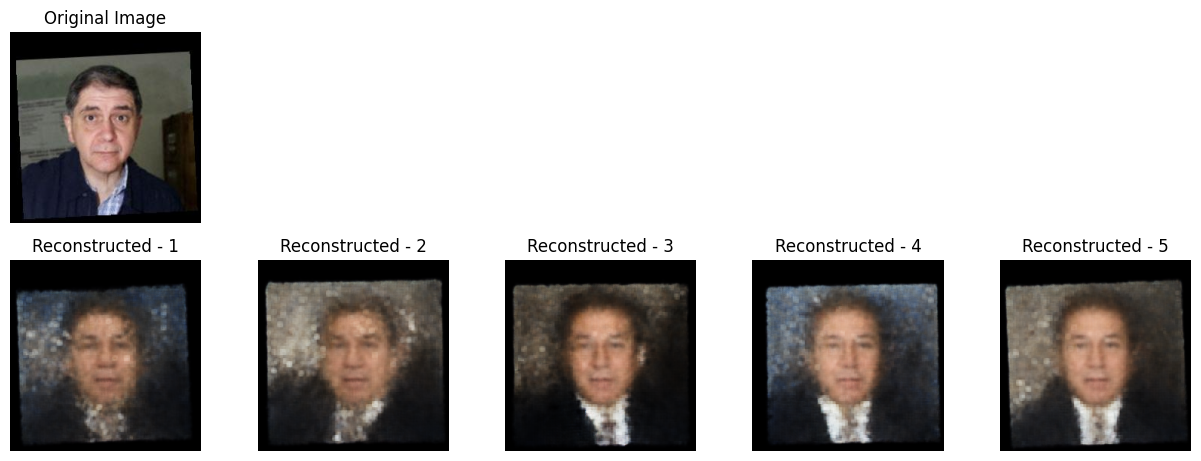

In [77]:
# Set VAE to evaluation mode
vae.eval()

# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)

    # Encode the image to get the latent space representation
    mu, logvar = vae.encode(original_image)

    # Reparameterize to sample from the latent space
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Plot the original and reconstructed images
    plt.figure(figsize=(15, 7))

    # Plot the original image
    plt.subplot(3, 6, 1)
    plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    # Generate and plot some reconstructed images with amplified variations
    for i in range(7, 12):
        # Introduce amplified variation
        z_varied = z + torch.randn_like(z) * 0.5  # Increase the variation factor accordingly

        # Decode the varied latent vector
        generated_image_varied = vae.decode(z_varied)

        # Plotting the regenerated images
        plt.subplot(3, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Reconstructed - {i-6}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
